In [2]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
#from lr_utils import load_dataset

%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
def load_dataset():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [4]:
#Load Training Data
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x_orig shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_orig shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


y = [1], it's a 'cat' picture.


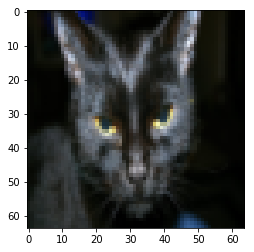

In [5]:
# Example of a picture
index = 25
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

In [41]:
# Reshape the training and test examples
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1)
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1)

#standardize our dataset
#see lab 1 notes for more info
train_set_x = train_set_x_flatten/255
test_set_x = test_set_x_flatten/255

print ("train_set_x shape: " + str(train_set_x.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))
print ("sanity check after reshaping: " + str(train_set_x[0:5,0]))

#Old
#train_set_x shape: (12288, 209)
#test_set_x shape: (12288, 50)

train_set_x shape: (209, 12288)
train_set_y shape: (1, 209)
test_set_x shape: (50, 12288)
test_set_y shape: (1, 50)
sanity check after reshaping: [ 17 196  82   1   9]
sanity check after reshaping: [0.06666667 0.76862745 0.32156863 0.00392157 0.03529412]


In [46]:
#convert numpy arrays to torch tensors
pt_train_set_x = torch.from_numpy(train_set_x).float()
pt_train_set_y = torch.from_numpy(train_set_y).float()
pt_test_set_x = torch.from_numpy(test_set_x).float()
pt_test_set_y = torch.from_numpy(test_set_y).float()


print (train_set_x.shape)
print (pt_train_set_x.shape)
print (train_set_y.shape)
print (pt_train_set_y.shape)
print (pt_train_set_x.type())


(209, 12288)
torch.Size([209, 12288])
(1, 209)
torch.Size([1, 209])
torch.FloatTensor


In [37]:
#Old
xx_data = Variable(torch.Tensor([[1.0], [2.0], [3.0], [4.0]]))
yy_data = Variable(torch.Tensor([[0.], [0.], [1.], [1.]]))

print (xx_data.shape)
print (xx_data.type())
print (yy_data.shape)

print (pt_train_set_x.shape)
print (type(pt_train_set_x))
print (pt_train_set_y.shape)

torch.Size([4, 1])
torch.FloatTensor
torch.Size([4, 1])
torch.Size([12288, 209])
<class 'torch.Tensor'>
torch.Size([1, 209])


In [47]:
class Model(torch.nn.Module):

    def __init__(self):
        """
        In the constructor we instantiate nn.Linear module
        """
        super(Model, self).__init__()
        self.linear = torch.nn.Linear(12288, 1)  # One in and one out

    def forward(self, x):
        """
        In the forward function we accept a Variable of input data and we must return
        a Variable of output data.
        """
        y_pred = F.sigmoid(self.linear(x))
        return y_pred

# our model
model = Model()

In [48]:
# Construct our loss function and an Optimizer. The call to model.parameters()
# in the SGD constructor will contain the learnable parameters of the two
# nn.Linear modules which are members of the model.
criterion = torch.nn.BCELoss(size_average=True)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


In [49]:
# Training loop
for epoch in range(1000):
        # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(pt_train_set_x)

    # Compute and print loss
    loss = criterion(y_pred, pt_train_set_y)
    print(epoch, loss.data[0])

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:1594: UserWarning: Using a target size (torch.Size([1, 209])) that is different to the input size (torch.Size([209, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  


0 tensor(0.6683)
1 tensor(0.8922)
2 tensor(2.0243)
3 tensor(3.2038)
4 tensor(0.8118)
5 tensor(1.8870)
6 tensor(3.1780)
7 tensor(0.7880)
8 tensor(1.8429)
9 tensor(3.1412)
10 tensor(0.7587)
11 tensor(1.7707)
12 tensor(3.1012)
13 tensor(0.7292)
14 tensor(1.6838)
15 tensor(3.0553)
16 tensor(0.6980)
17 tensor(1.5764)
18 tensor(2.9986)
19 tensor(0.6629)
20 tensor(1.4341)
21 tensor(2.9161)
22 tensor(0.6189)
23 tensor(1.2096)
24 tensor(2.7408)
25 tensor(0.5550)
26 tensor(0.7158)
27 tensor(1.7355)
28 tensor(1.1469)
29 tensor(2.6554)
30 tensor(0.5311)
31 tensor(0.5689)
32 tensor(0.9581)
33 tensor(1.8575)
34 tensor(2.8965)
35 tensor(0.5964)
36 tensor(1.1887)
37 tensor(2.6429)
38 tensor(0.5149)
39 tensor(0.5666)
40 tensor(1.0351)
41 tensor(1.7670)
42 tensor(2.8319)
43 tensor(0.5613)
44 tensor(1.0303)
45 tensor(2.4254)
46 tensor(0.5053)
47 tensor(0.6112)
48 tensor(1.3072)
49 tensor(2.6601)
50 tensor(0.5002)
51 tensor(0.6270)
52 tensor(1.4340)
53 tensor(1.3054)
54 tensor(2.6315)
55 tensor(0.4888)
56

470 tensor(0.4367)
471 tensor(0.5392)
472 tensor(0.4339)
473 tensor(0.5341)
474 tensor(0.4311)
475 tensor(0.5290)
476 tensor(0.4283)
477 tensor(0.5239)
478 tensor(0.4254)
479 tensor(0.5189)
480 tensor(0.4226)
481 tensor(0.5138)
482 tensor(0.4197)
483 tensor(0.5088)
484 tensor(0.4168)
485 tensor(0.5038)
486 tensor(0.4139)
487 tensor(0.4988)
488 tensor(0.4110)
489 tensor(0.4938)
490 tensor(0.4080)
491 tensor(0.4888)
492 tensor(0.4051)
493 tensor(0.4839)
494 tensor(0.4021)
495 tensor(0.4789)
496 tensor(0.3992)
497 tensor(0.4740)
498 tensor(0.3962)
499 tensor(0.4690)
500 tensor(0.3932)
501 tensor(0.4641)
502 tensor(0.3902)
503 tensor(0.4592)
504 tensor(0.3871)
505 tensor(0.4544)
506 tensor(0.3841)
507 tensor(0.4495)
508 tensor(0.3811)
509 tensor(0.4446)
510 tensor(0.3780)
511 tensor(0.4398)
512 tensor(0.3749)
513 tensor(0.4350)
514 tensor(0.3719)
515 tensor(0.4302)
516 tensor(0.3688)
517 tensor(0.4254)
518 tensor(0.3657)
519 tensor(0.4207)
520 tensor(0.3626)
521 tensor(0.4159)
522 tensor(0

935 tensor(0.1218)
936 tensor(0.1217)
937 tensor(0.1217)
938 tensor(0.1216)
939 tensor(0.1215)
940 tensor(0.1214)
941 tensor(0.1213)
942 tensor(0.1212)
943 tensor(0.1211)
944 tensor(0.1211)
945 tensor(0.1210)
946 tensor(0.1209)
947 tensor(0.1208)
948 tensor(0.1207)
949 tensor(0.1206)
950 tensor(0.1205)
951 tensor(0.1205)
952 tensor(0.1204)
953 tensor(0.1203)
954 tensor(0.1202)
955 tensor(0.1201)
956 tensor(0.1200)
957 tensor(0.1200)
958 tensor(0.1199)
959 tensor(0.1198)
960 tensor(0.1197)
961 tensor(0.1196)
962 tensor(0.1195)
963 tensor(0.1195)
964 tensor(0.1194)
965 tensor(0.1193)
966 tensor(0.1192)
967 tensor(0.1191)
968 tensor(0.1190)
969 tensor(0.1190)
970 tensor(0.1189)
971 tensor(0.1188)
972 tensor(0.1187)
973 tensor(0.1186)
974 tensor(0.1186)
975 tensor(0.1185)
976 tensor(0.1184)
977 tensor(0.1183)
978 tensor(0.1182)
979 tensor(0.1181)
980 tensor(0.1181)
981 tensor(0.1180)
982 tensor(0.1179)
983 tensor(0.1178)
984 tensor(0.1177)
985 tensor(0.1177)
986 tensor(0.1176)
987 tensor(0

In [15]:
# After training
#hour_var = Variable(torch.Tensor([[1.0]]))
#print("predict 1 hour ", 1.0, model(hour_var).data[0][0] > 0.5)


predict 1 hour  1.0 tensor(0, dtype=torch.uint8)
predict 7 hours 9.0 tensor(1, dtype=torch.uint8)


C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


The Algo says tensor([[1.]], grad_fn=<SigmoidBackward>)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


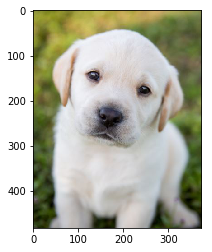

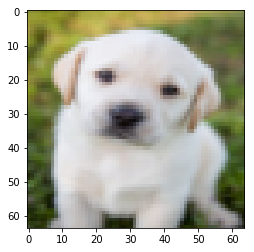

In [60]:
#Test Image 
#fname = "datasets/cat1.JPG"  #LR is good
#fname = "datasets/cat3.JPG"  #LR is bad
#fname = "datasets/cat4.JPG"  #LR is good
#fname = "datasets/cartoon_grump.JPG"   #LR is bad
#fname = "datasets/puss.JPG"   #LR is bad
#fname = "datasets/meandog.JPG"  #LR is good
fname = "datasets/puppy.JPG"  #LR is good
image = np.array(ndimage.imread(fname, flatten=False))
resized_image = scipy.misc.imresize(image, size=(64,64))
my_image = resized_image.reshape((1, 64*64*3))
pt_my_image = torch.from_numpy(my_image).float()


print ("The Algo says " + str(model(pt_my_image)))
plt.imshow(image)
plt.show()
plt.imshow(resized_image)